In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F

from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (mpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=80, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=80, out_features=10, bias=True)
)


## Transform the dataset

In [21]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from data_load import PhoneNumberDataset
from data_load import Normalize, Gray_scale_Image, ToTensor, Gray_scale_to_Binary, BoundingBoxes

data_transform = transforms.Compose([Gray_scale_Image(), BoundingBoxes(), ToTensor()])

assert(data_transform is not None)

In [22]:
data_frame = pd.read_csv("data\phone_numbers_dataset.csv")
data_frame = shuffle(data_frame)
data_frame = data_frame.reset_index(drop=True)

train_df = data_frame.iloc[0:30000]
# train_df.to_csv('train_df.csv', index=False)

test_df = data_frame.iloc[30000:35000]
test_df = test_df.reset_index(drop=True)
# test_df.to_csv('test_df.csv', index=False)

cross_valid_df = data_frame.iloc[35000:40000]
cross_valid_df = cross_valid_df.reset_index(drop=True)
# cross_valid_df.to_csv('cross_valid_df.csv', index=False)

display(train_df, test_df, cross_valid_df)

,image_id,phone_number
0,phoneNumberImage3614.png,9499456018
1,phoneNumberImage2140.png,8172810974
2,phoneNumberImage6750.png,9403312217
3,phoneNumberImage1359.png,171353698
4,phoneNumberImage24176.png,8109933967
...,...,...
29995,phoneNumberImage17312.png,3038010539
29996,phoneNumberImage7419.png,1487672500
29997,phoneNumberImage30894.png,5586733538
29998,phoneNumberImage4721.png,1206530284


,image_id,phone_number
0,phoneNumberImage23108.png,9461079012
1,phoneNumberImage240.png,8208759502
2,phoneNumberImage32578.png,6125766637
3,phoneNumberImage4127.png,8945355584
4,phoneNumberImage34201.png,5046353097
...,...,...
4995,phoneNumberImage4938.png,2712105756
4996,phoneNumberImage30646.png,3942717499
4997,phoneNumberImage13089.png,9747469364
4998,phoneNumberImage34096.png,8935034628


,image_id,phone_number
0,phoneNumberImage45.png,6234677195
1,phoneNumberImage2557.png,9284007026
2,phoneNumberImage20965.png,1911177856
3,phoneNumberImage34459.png,1007578510
4,phoneNumberImage33353.png,351514745
...,...,...
4995,phoneNumberImage8161.png,7880968662
4996,phoneNumberImage29761.png,6352571217
4997,phoneNumberImage325.png,6669283049
4998,phoneNumberImage539.png,7441778005


In [23]:
transformed_dataset = PhoneNumberDataset(csv_file=os.path.join('data\\', 'train_df.csv'),
                                                root_dir='data\phone_number_images\\',
                                                transform=data_transform)

for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), len(sample['digits_list']))

0 torch.Size([10, 28, 28]) 10
1 torch.Size([10, 28, 28]) 10
2 torch.Size([10, 28, 28]) 10
3 torch.Size([10, 28, 28]) 10
4 torch.Size([10, 28, 28]) 10


In [24]:
batch_size = 32

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [25]:
test_dataset = PhoneNumberDataset(csv_file=os.path.join('data\\', 'test_df.csv'), root_dir='data\phone_number_images\\', transform=data_transform)

for i in range(5):
    sample = test_dataset[i]
    print(i, sample['image'].size(), len(sample['digits_list']))
    print(sample['digits_list'])

0 torch.Size([10, 28, 28]) 10
[5, 5, 2, 3, 4, 0, 9, 8, 5, 2]
1 torch.Size([10, 28, 28]) 10
[6, 6, 0, 0, 8, 2, 6, 4, 5, 8]
2 torch.Size([10, 28, 28]) 10
[9, 3, 3, 9, 7, 5, 3, 5, 1, 0]
3 torch.Size([10, 28, 28]) 10
[7, 1, 3, 1, 0, 7, 5, 9, 4, 9]
4 torch.Size([10, 28, 28]) 10
[1, 6, 8, 6, 0, 4, 2, 2, 4, 7]


In [26]:
batch_size = 32
test_loader = DataLoader(test_dataset,
                        batch_size,
                        shuffle=True,
                        num_workers=0)

In [27]:
def net_sample_output():
    for i, sample in enumerate(test_loader):
        images = sample['image']
        phone_num_digits_list = sample['digits_list']
        images = images.type(torch.FloatTensor)
        output_digits = net(images)
        print(output_digits[i])
        output_digits = torch.argmax(output_digits, dim=1)
        output_digits = output_digits.view(output_digits.size()[0], -1)
        if i == 0:
            return images, output_digits, phone_num_digits_list

In [28]:
test_images, test_outputs, ground_truth_output = net_sample_output()
print(test_images.data.size())
print(test_outputs.data.size())
print(len(ground_truth_output))

tensor([2.0173e-05, 8.9908e-06, 3.2649e-05, 3.4004e-02, 3.2894e-03, 1.9227e-05,
        9.6213e-01, 7.1243e-05, 1.3788e-06, 4.2251e-04],
       grad_fn=<SelectBackward0>)
torch.Size([32, 10, 28, 28])
torch.Size([320, 1])
10


In [29]:
def show_Image(image):
    plt.imshow(image, cmap='gray')

def visualize_output(test_images, test_outputs, ground_truth_output, batch_size=3):
    for i in range(batch_size):
        plt.figure(figsize=(20,20))
        ax = plt.subplot(1, batch_size, i+1)

        image = test_images[i].data
        image = image.numpy()

        test_digits = test_outputs[i*10:i*10 + 10].data.reshape((10))
        test_digits = test_digits.numpy()
        
        print("test digits: ", test_digits)
        
        grond_digits = [x.data.numpy() for x in ground_truth_output]
        grond_digits = np.asarray(grond_digits).T
        grond_digits = grond_digits[i]

        print("ground digits: ", grond_digits)

        # digits_list = [x.data.numpy() for x in ground_truth_output]
        # digits_batch = torch.Tensor(np.transpose(np.asarray(digits_list)))
        # digits_one_hot = []
        # for phone_num in digits_batch:
        #     one_hot_encoded_digit = F.one_hot(phone_num.type(torch.LongTensor), num_classes=10)
        #     digits_one_hot.append(one_hot_encoded_digit)
        # digits_one_hot_tensor = [x.data.numpy() for x in digits_one_hot]
        # digits_one_hot_tensor = np.array(digits_one_hot_tensor)
        # digits_one_hot_tensor = torch.Tensor(digits_one_hot_tensor)

        # digits_one_hot_tensor_sample = digits_one_hot_tensor[i]

        # ground_truth_digits_argmax = torch.argmax(digits_one_hot_tensor, dim=2)

        # print("after argmax: ", ground_truth_digits_argmax[i])
        # print("original digits list: ", grond_digits)

        for j, img in enumerate(image):
            # print(digits_one_hot_tensor_sample[j])
            ax = plt.subplot(1, 10, j + 1)
            ax.set_title(str(grond_digits[j]) + "  " + str(test_digits[j]))
            show_Image(img)
    plt.show()

test digits:  [6 6 4 4 0 3 4 2 1 4]
ground digits:  [9 5 9 3 3 5 0 6 8 4]
test digits:  [0 3 1 1 4 7 4 0 4 4]
ground digits:  [8 4 1 3 8 1 5 7 1 6]
test digits:  [4 4 6 7 4 1 4 4 1 6]
ground digits:  [9 1 7 1 4 6 4 1 9 1]


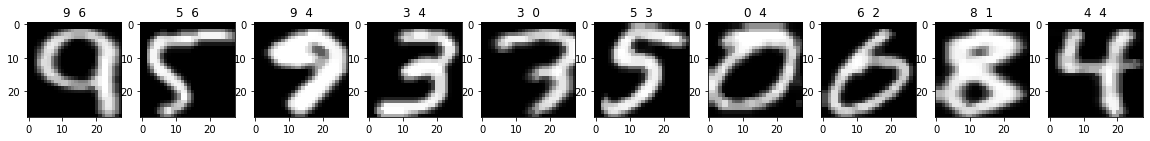

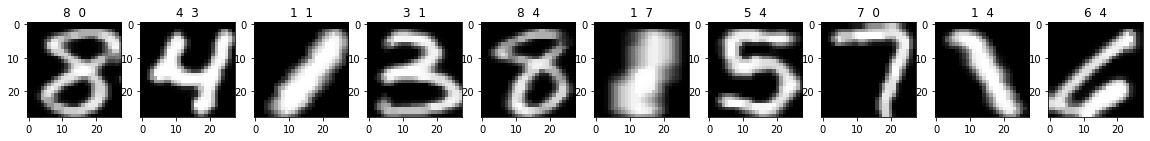

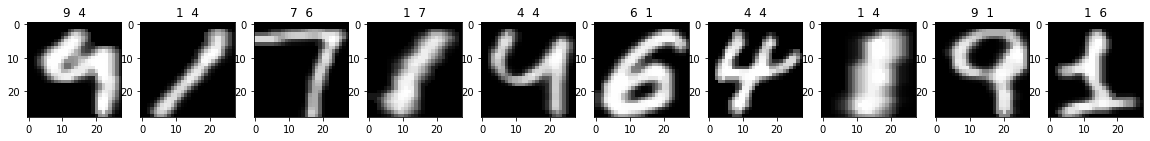

In [30]:
visualize_output(test_images, test_outputs, ground_truth_output=ground_truth_output)

## Training

In [31]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters())

In [32]:
def train_net(n_epochs):
    
    net.train()

    for epoch in range(n_epochs):

        running_loss = 0.0
        running_accu = 0.0

        for batch_i, data in enumerate(train_loader):

            images = data['image']
            digits_list = data['digits_list']

            digits_list = [x.data.numpy() for x in digits_list]
            digits_batch = torch.Tensor(np.transpose(np.asarray(digits_list)))
            # print(digits_batch)
            digits_batch = torch.reshape(digits_batch,(digits_batch.size(0)*digits_batch.size(1), ))
            # print(digits_batch.size())
            digits_one_hot = []
            for phone_num in digits_batch:
                one_hot_encoded_digit = F.one_hot(phone_num.type(torch.LongTensor), num_classes=10)
                digits_one_hot.append(one_hot_encoded_digit)
            digits_one_hot_tensor = [x.data.numpy() for x in digits_one_hot]
            digits_one_hot_tensor = np.array(digits_one_hot_tensor)
            digits_one_hot_tensor = torch.Tensor(digits_one_hot_tensor)
            images = images.type(torch.FloatTensor)

            output_digits = net(images)
            
            output_digits = output_digits.type(torch.FloatTensor)
            #Accuracy
            out = torch.argmax(output_digits, dim=1)            
            # print(out.size())
            accuracy = out == digits_batch
            accuracy = torch.sum(accuracy.detach()).float()

            loss = criterion(output_digits, digits_one_hot_tensor.float())

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            running_accu += accuracy

            if(batch_i % 10 == 9):
                print(f'Epoch: {epoch + 1}, Batch: {batch_i + 1}, Avg. Loss: {running_loss / 10}, Avg. Accu: {running_accu}')
                running_accu = 0.0
                running_loss = 0.0
                
    print("Training is finished")

In [33]:
n_epochs = 10

train_net(n_epochs) # Each step in output has 3200 images of single digit

Epoch: 1, Batch: 10, Avg. Loss: 2.296380376815796, Avg. Accu: 516.0
Epoch: 1, Batch: 20, Avg. Loss: 2.2530701875686647, Avg. Accu: 665.0
Epoch: 1, Batch: 30, Avg. Loss: 2.20807945728302, Avg. Accu: 809.0
Epoch: 1, Batch: 40, Avg. Loss: 2.222129726409912, Avg. Accu: 765.0
Epoch: 1, Batch: 50, Avg. Loss: 2.202732801437378, Avg. Accu: 826.0
Epoch: 1, Batch: 60, Avg. Loss: 2.1923250913619996, Avg. Accu: 859.0
Epoch: 1, Batch: 70, Avg. Loss: 2.145042657852173, Avg. Accu: 1008.0
Epoch: 1, Batch: 80, Avg. Loss: 2.0909307479858397, Avg. Accu: 1182.0
Epoch: 1, Batch: 90, Avg. Loss: 2.075859308242798, Avg. Accu: 1233.0
Epoch: 1, Batch: 100, Avg. Loss: 2.0615998029708864, Avg. Accu: 1277.0
Epoch: 1, Batch: 110, Avg. Loss: 2.043901205062866, Avg. Accu: 1333.0
Epoch: 1, Batch: 120, Avg. Loss: 1.9856165885925292, Avg. Accu: 1516.0
Epoch: 1, Batch: 130, Avg. Loss: 1.970433282852173, Avg. Accu: 1569.0
Epoch: 1, Batch: 140, Avg. Loss: 1.9618223071098329, Avg. Accu: 1597.0
Epoch: 1, Batch: 150, Avg. Los

In [34]:
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([64, 1, 3, 3])
conv1.bias 	 torch.Size([64])
conv2.weight 	 torch.Size([64, 64, 3, 3])
conv2.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([80, 1600])
fc1.bias 	 torch.Size([80])
fc2.weight 	 torch.Size([10, 80])
fc2.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {0: {'step': 9380, 'exp_avg': tensor([[[[ 1.5519e-02,  1.5515e-02,  1.6268e-02],
          [ 1.7523e-02,  1.7408e-02,  1.8216e-02],
          [ 1.9005e-02,  1.8377e-02,  1.9668e-02]]],


        [[[-2.3680e-03, -8.0082e-04, -6.8388e-05],
          [-3.2493e-03, -1.3066e-03, -2.3445e-04],
          [-3.3985e-03, -1.2201e-03, -2.6670e-04]]],


        [[[-1.0238e-03, -3.7142e-03, -6.1066e-03],
          [-2.1318e-03, -6.5585e-03, -1.0637e-02],
          [-1.9557e-03, -6.2531e-03, -1.1203e-02]]],


        [[[-2.6266e-03, -2.7360e-03, -2.7812e-03],
          [-1.3256e-03, -1.5787e-03, -9.4018e-04],
          [-8.3741e-04, -5.8590e-04,  2.2404e-04]]],


        [[[-1.0245e-0

In [35]:
torch.save(net.state_dict(), os.path.join("data\models\model_basic\\", "statedictmodelWith10EpochOperaAppliedOnEachDigitBatchSize320.pth"))

In [36]:
# loaded_model = torch.load("data\models\model_basic\model_1.pth")

In [37]:
net = Net()
net.load_state_dict(torch.load("data\models\model_basic\statedictmodelWith10EpochOperaAppliedOnEachDigitBatchSize320.pth"))
print(net)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (mpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=80, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=80, out_features=10, bias=True)
)
